In [1]:
import os
from data_loader.calib.intrinsic_extrinsic_loader import IntrinsicExtrinsicLoader
from data_loader.file_loader import FileLoader
from data_loader.file_writer import FileWriter
from tools.utils import *

In [2]:
def visualize_depthmap(dataset_path, calib_path, kitti360_path, platform, sequence_name):
  # Platform
  if platform == 'handheld':
    from cfg.dataset.cfg_handheld import dataset_sensor_frameid_dict
    from cfg.dataset.cfg_handheld import dataset_rostopic_msg_frameid_dict
  elif platform == 'ugv':
    from cfg.dataset.cfg_ugv import dataset_sensor_frameid_dict
    from cfg.dataset.cfg_ugv import dataset_rostopic_msg_frameid_dict
  elif platform == 'legged':
    from cfg.dataset.cfg_legged import dataset_sensor_frameid_dict
    from cfg.dataset.cfg_legged import dataset_rostopic_msg_frameid_dict
    if sequence_name == 'legged_grass00':
      dataset_sensor_frameid_dict, dataset_rostopic_msg_frameid_dict = \
        filter_sensor('event', dataset_sensor_frameid_dict, dataset_rostopic_msg_frameid_dict)
  elif platform =='vehicle':
    from cfg.dataset.cfg_vehicle import dataset_sensor_frameid_dict
    from cfg.dataset.cfg_vehicle import dataset_rostopic_msg_frameid_dict

  ##### Set up the sensor configuration
  int_ext_loader = IntrinsicExtrinsicLoader(is_print=False)
  int_ext_loader.load_calibration(calib_path=calib_path, sensor_frameid_dict=dataset_sensor_frameid_dict)
  # print('Finish loading parameters')

  ##### Visualize TF-tree
  # int_ext_loader.tf_graph.visualize_graph()

  ##### Generate depth map
  # Description: Generate depth map
  import cv2
  import open3d
  from PIL import Image
  from IPython.display import display
  import matplotlib.pyplot as plt
  import copy
  cmap = plt.get_cmap('jet')
  cmap_colors = cmap(np.linspace(0, 1, 31)) * 255

  ##### Load extrinsics from the tf_graph
  if platform == 'vehicle':
    camera = int_ext_loader.sensor_collection['vehicle_frame_left_camera']
  else:
    camera = int_ext_loader.sensor_collection['frame_left_camera']
  T_cam_sensor = int_ext_loader.tf_graph.get_relative_transform(camera.frame_id, 'body_imu')
  # print(T_cam_sensor)

  frame_id = 4000
  ##### Load point cloud and image
  pcd_path = os.path.join(kitti360_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(frame_id))
  if os.path.exists(pcd_path):
    if platform == 'vehicle':
      img_path = os.path.join(kitti360_path, 'vehicle_frame_cam00', 'image/data', '{:06d}.png'.format(frame_id)) # images are already undistorted, but not rectified
      img = cv2.imread(img_path)
    else:
      img_path = os.path.join(kitti360_path, 'frame_cam00', 'image/data', '{:06d}.png'.format(frame_id)) # images are already undistorted, but not rectified
      img = cv2.imread(img_path)

    xyz_points = np.asarray(open3d.io.read_point_cloud(pcd_path).points)
    xyz_points_cam = np.matmul(T_cam_sensor[:3, :3], xyz_points.T).T + T_cam_sensor[:3, 3].T

    ##### Project point cloud onto the camera frame
    ratio = 1
    for _, p_C in enumerate(xyz_points_cam):
      flag, u_C = camera.project(p_C)
      if flag:
        i = int(min(p_C[2], 30.0))
        color = (int(cmap_colors[i, 0]), int(cmap_colors[i, 1]), int(cmap_colors[i, 2]))
        cv2.circle(img, (int(u_C[0]), int(u_C[1])), radius=1, color=color, thickness=-1)
    img_pillow = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    display(img_pillow.resize((img_pillow.size[0] // ratio, img_pillow.size[1] // ratio)))

    ##### Project point cloud onto the depth camera frame
    ratio = 2
    depth_img = np.zeros((camera.height, camera.width), dtype=np.uint32)
    for p_C in xyz_points_cam:
      flag, u_C = camera.project(p_C)
      if flag:
        depth_img[int(u_C[1])][int(u_C[0])] = np.uint32(p_C[2] * 1000)
    img_pillow = Image.fromarray(depth_img)
    display(img_pillow.resize((img_pillow.size[0] // ratio, img_pillow.size[1] // ratio)))

Start processing platform: vehicle sequence: vehicle_campus00 with algorithm_result: fastlio2
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
['vehicle_frame_cam00', 'body_imu']


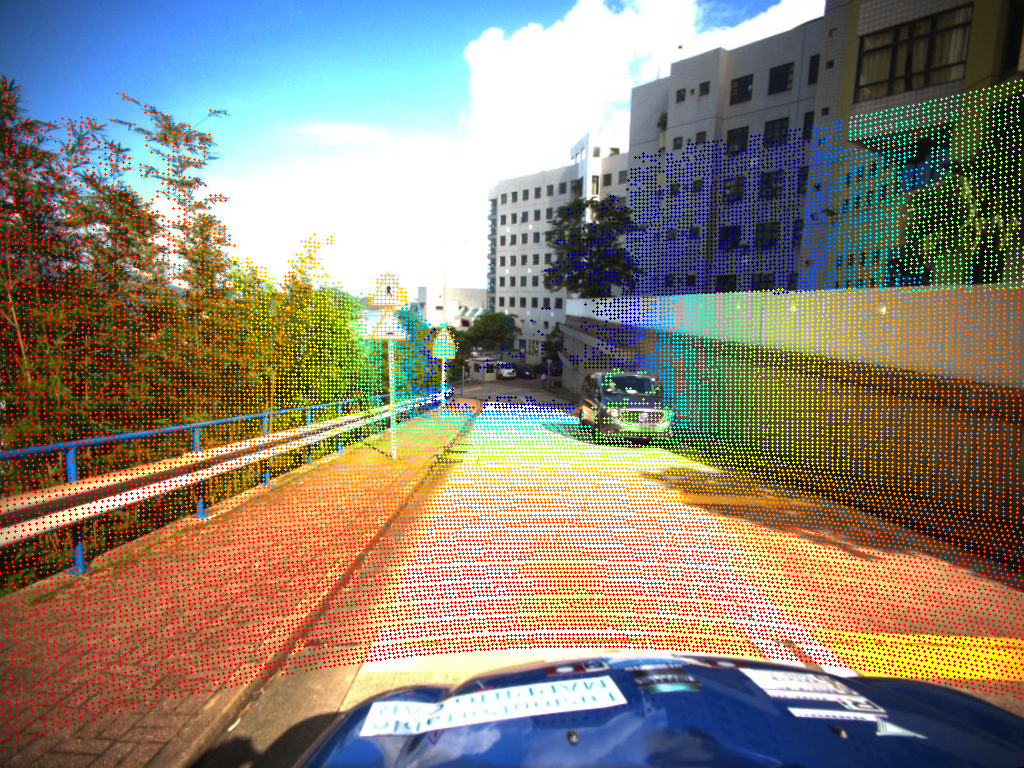

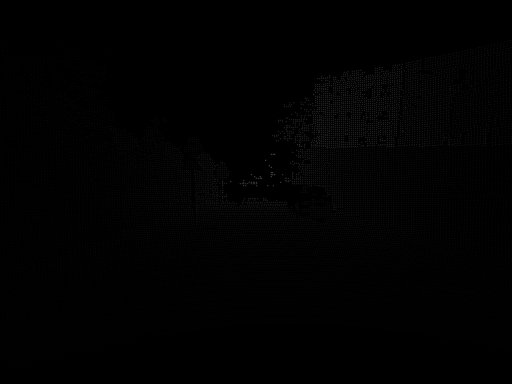

In [3]:
use_lists = [False, False, False, False, False, False, True, False]
platforms = ['handheld', 'handheld', 'legged', 'legged', 'ugv', 'ugv', 'vehicle', 'vehicle']
sequence_names = ['handheld_starbucks00',	'handheld_room00', 'legged_room00', 'legged_grass00', 'ugv_campus00', 'ugv_parking00', 'vehicle_campus00', 'vehicle_highway00']
algorithms = ['fastlio2']
str_dates = ['20230426_calib', '20230426_calib', '20230426_calib', '20230426_calib', '20230426_calib', '20230426_calib', '20230618_calib', '20230618_calib' ]
for used, platform, sequence_name, str_date in zip(use_lists, platforms, sequence_names, str_dates):
  for algorithm in algorithms:
    if used:
      print('Start processing platform: {} sequence: {} with algorithm_result: {}'.format(platform, sequence_name, algorithm))
      dataset_path = '/Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined'
      calib_path = os.path.join(dataset_path, '../../calibration_files', str_date, 'calib')
      kitti360_path = os.path.join(dataset_path, sequence_name, 'kitti360')
      visualize_depthmap(dataset_path, calib_path, kitti360_path, platform, sequence_name)

In [4]:
name, str_date in zip(use_lists, platforms, sequence_names, str_dates):
  for algorithm in algorithms:
    if used:
      print('Start processing platform: {} sequence: {} with algorithm_result: {}'.format(platform, sequence_name, algorithm))
      dataset_path = '/Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined'
      # calib_path = os.path.join(dataset_path, '../../calibration_files', str_date, 'calib')
      calib_path = '/home/jjiao/mapping_ws/src/ramlab-dataset-code/fusionportable_dataset_tools/calibration_files/20230618_calib/calib'
      kitti360_path = os.path.join(dataset_path, sequence_name, 'kitti360')
      visualize_depthmap(dataset_path, calib_path, kitti360_path, platform, sequence_name)

SyntaxError: invalid syntax (593988331.py, line 1)